In [10]:
import xarray as xr
import numpy as np

import datetime
import matplotlib.pyplot as plt
import glob

In [6]:
ports = {
    'churchill': (58.7745, -94.1935),
}
ds = xr.open_mfdataset(glob.glob('data/hb_era5_glorys_nc/*.nc'))
mask = np.isnan(ds.siconc.isel(time=0))

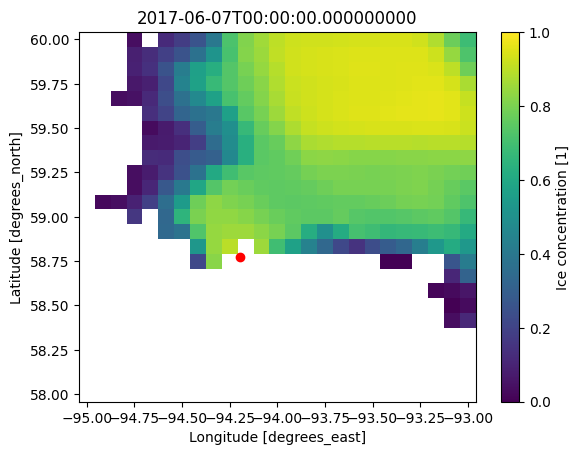

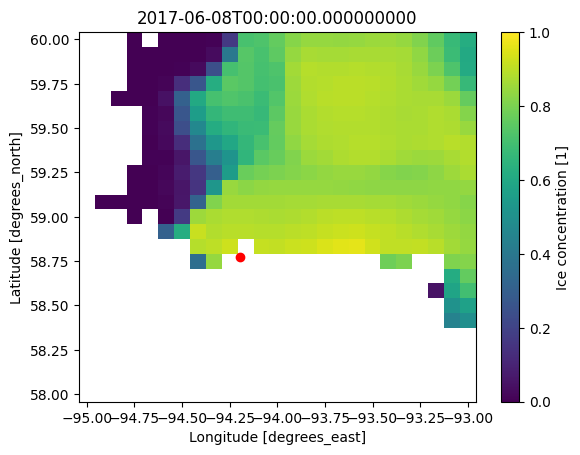

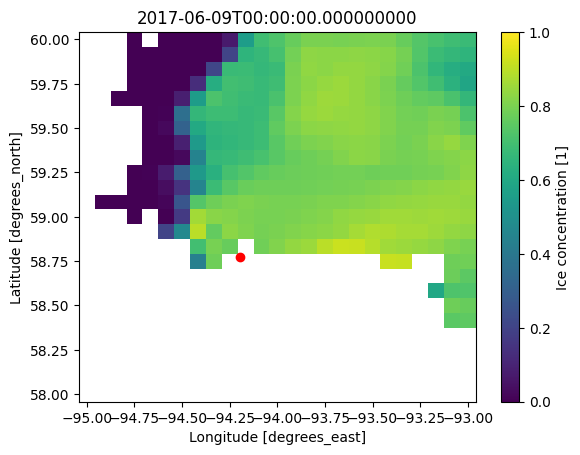

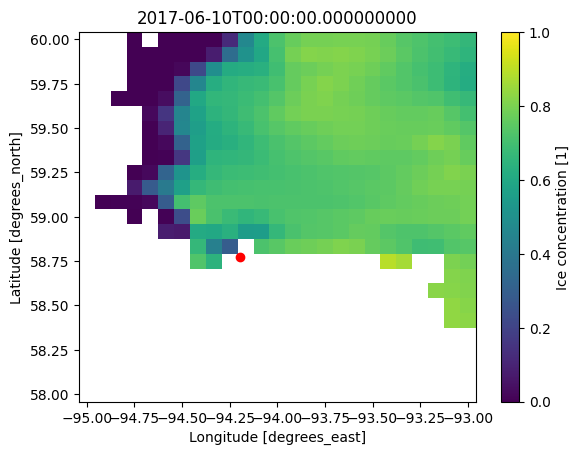

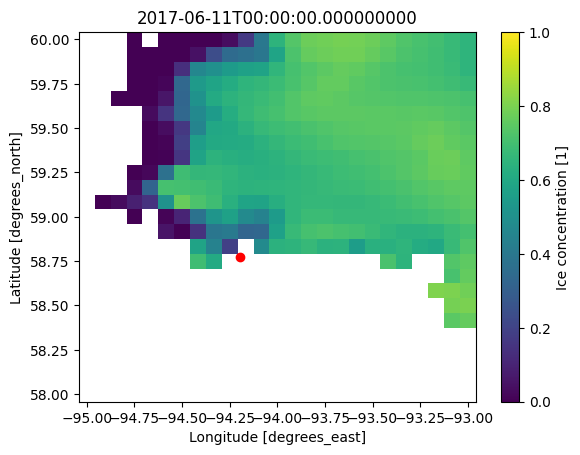

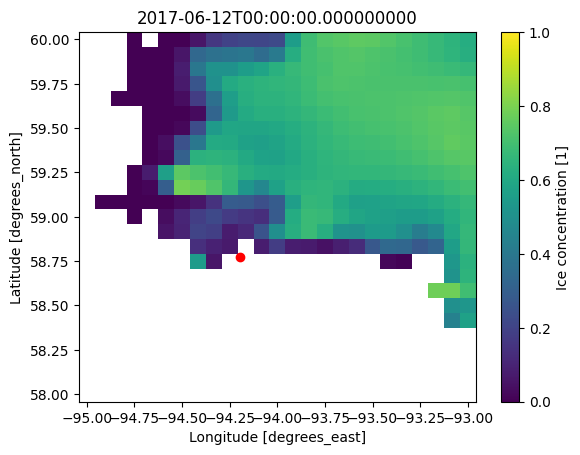

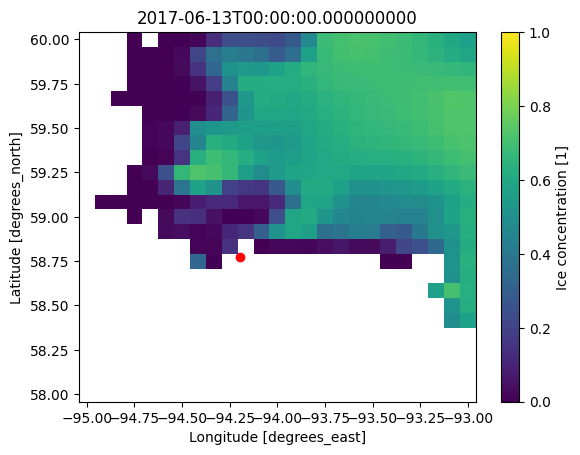

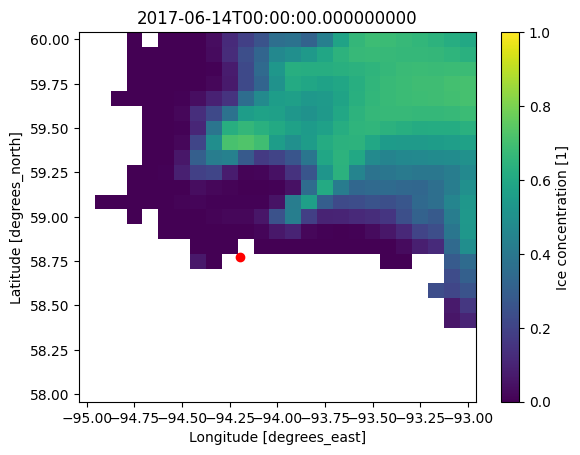

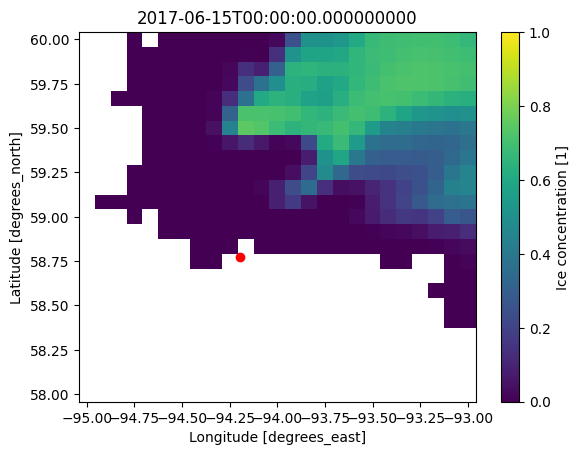

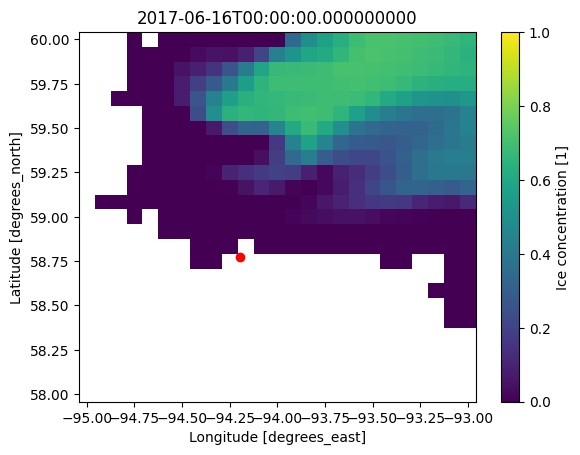

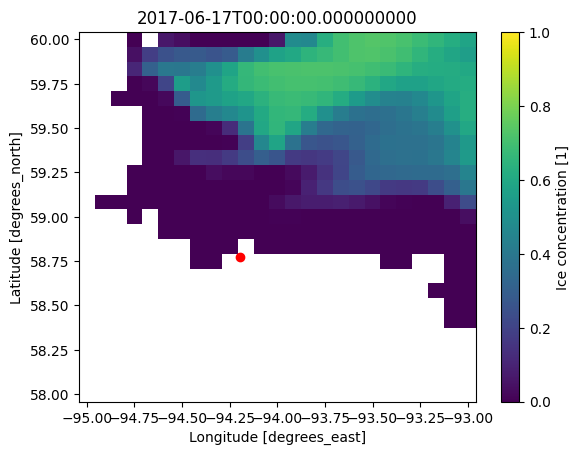

In [11]:
ds_ch = ds.sel(latitude=slice(58, 60), longitude=slice(-95, -93))
mask_ch = mask.sel(latitude=slice(58, 60), longitude=slice(-95, -93))
ds_ch = ds_ch.sel(time=slice(datetime.datetime(2017, 6, 7), datetime.datetime(2017, 6, 17)))

for t in ds_ch.time.values:
    ds_ch.sel(time=t).fillna(0).where(~mask_ch).siconc.plot(vmin=0, vmax=1)
    plt.scatter(ports['churchill'][1], ports['churchill'][0], c='r')
    plt.title(t)
    plt.show()